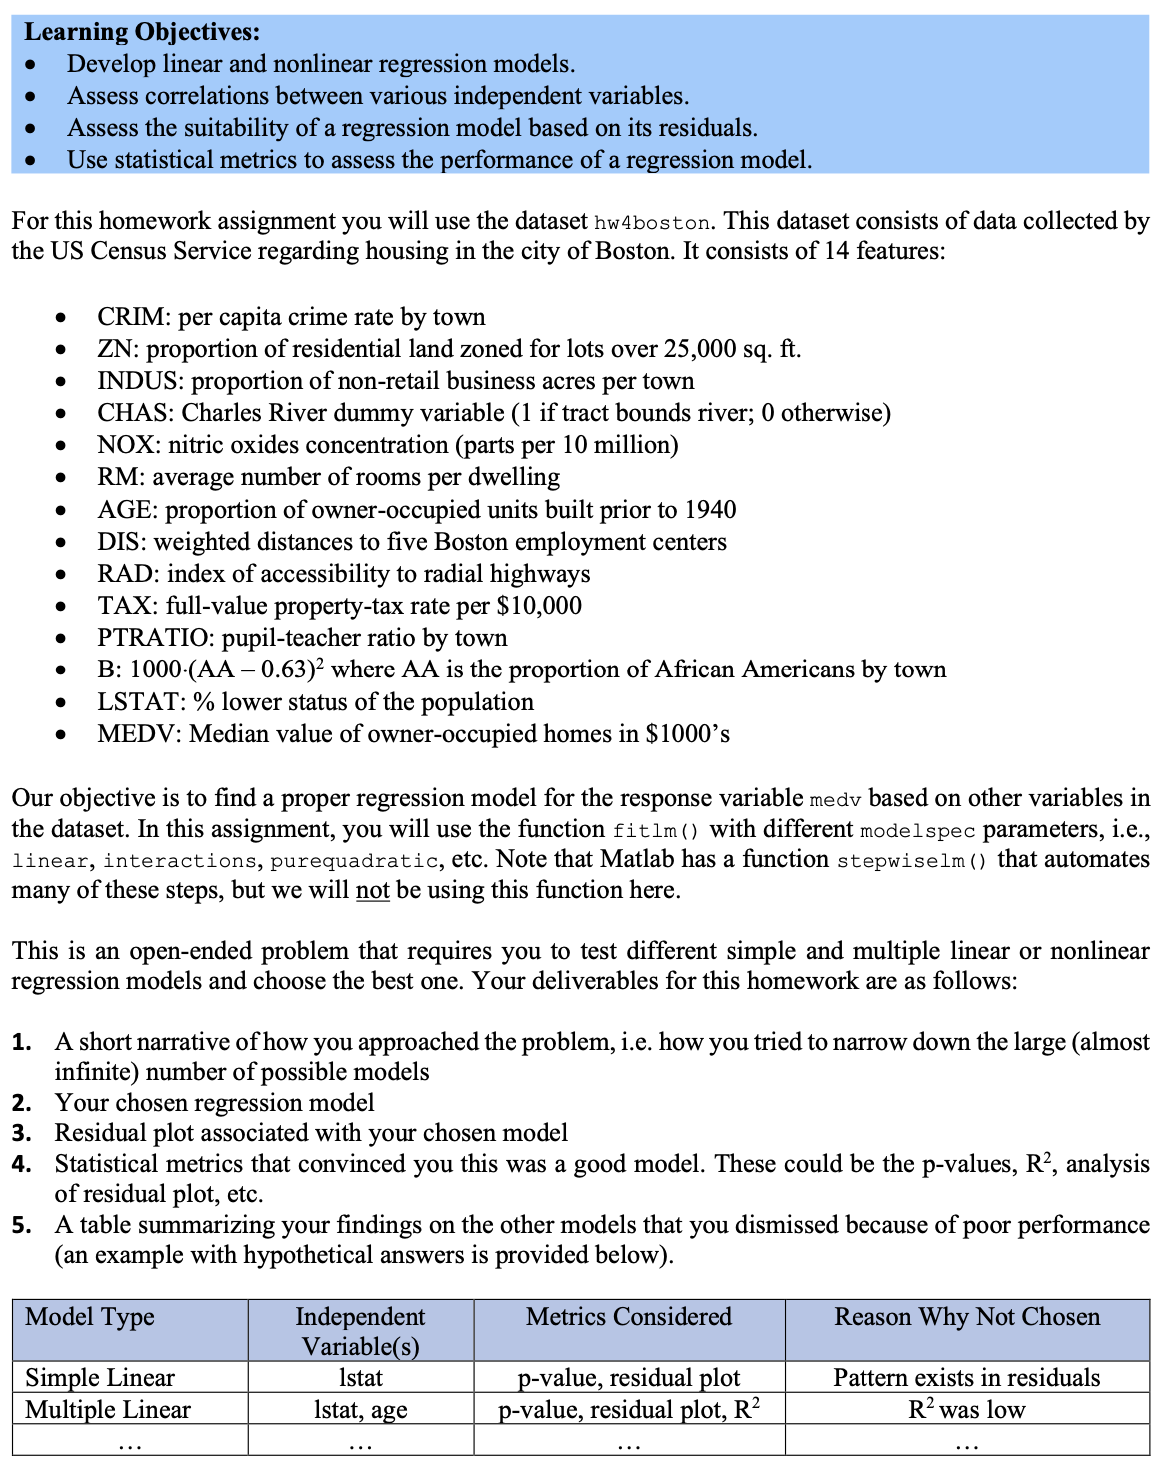

This is an open-ended project, for which there is no definitive solution. However, your work will be graded based on the following rubric:

1. Narrative of how you approached the problem (maximum of 2 points)
    - Clear, detailed, reasonable approach (2 points)
    - Discussion is not clear or not detailed enough (1 point)
    - No narrative (0 points)
1. Summary Table (maximum of 4 points)
    -Various possibilities have been considered in terms of the types of models and the variables included. List of metrics is comprehensive. Justification behind not selecting the model is reasonable (4 points)
    - Each item lacking or insufficient (lose 1 point)
    - No table provided (0 points) 
1. Your chosen regression model (maximum of 4 points)
    - A model is chosen (1 point)
    - Residual plot associated with the model is presented (1 point)
    - Statistical metrics are provided for the chosen model (1 point)
    - Choice of model is reasonable (1 point)

### The first thing I am going to try to figure out is which features to include in my regression model.

 Narrowing down the features will help with interpretability. 

First I am going to look at the pairwise correlations of the *numeric* variables. This is all the variables except **CHAS**. I will later decide if it makes sense to include that feature. (I imagine it does. As Mark Twain says, "buy land, they're not making it anymore", and this is especially true for primo waterfront property.)

I'll be looking to remove features with near-zero variance or ones that are highly correlated with others.

In [281]:
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np


%config InlineBackend.figure_format = 'retina'

df = pd.read_csv("./hw4boston.csv")
df

crim    zn  indus  chas    nox     rm   age     dis  rad  tax  \
0    0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296   
1    0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242   
2    0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242   
3    0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222   
4    0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222   
..       ...   ...    ...   ...    ...    ...   ...     ...  ...  ...   
501  0.06263   0.0  11.93     0  0.573  6.593  69.1  2.4786    1  273   
502  0.04527   0.0  11.93     0  0.573  6.120  76.7  2.2875    1  273   
503  0.06076   0.0  11.93     0  0.573  6.976  91.0  2.1675    1  273   
504  0.10959   0.0  11.93     0  0.573  6.794  89.3  2.3889    1  273   
505  0.04741   0.0  11.93     0  0.573  6.030  80.8  2.5050    1  273   

     ptratio       b  lstat  medv  
0       15.3  396.90   4.98  24.0  
1       17.8  396.90   9.14  21.6  
2       17.8  392.83   4.03  34.7  
3       18.7  394.63   2.94  33.4  
4       18.7  396.90   5.33  36.2  
..       ...     ...    ...   ...  
501     21.0  391.99   9.67  22.4  
502     21.0  396.90   9.08  20.6  
503     21.0  396.90   5.64  23.9  
504     21.0  393.45   6.48  22.0  
505     21.0  396.90   7.88  11.9  

[506 rows x 14 columns]

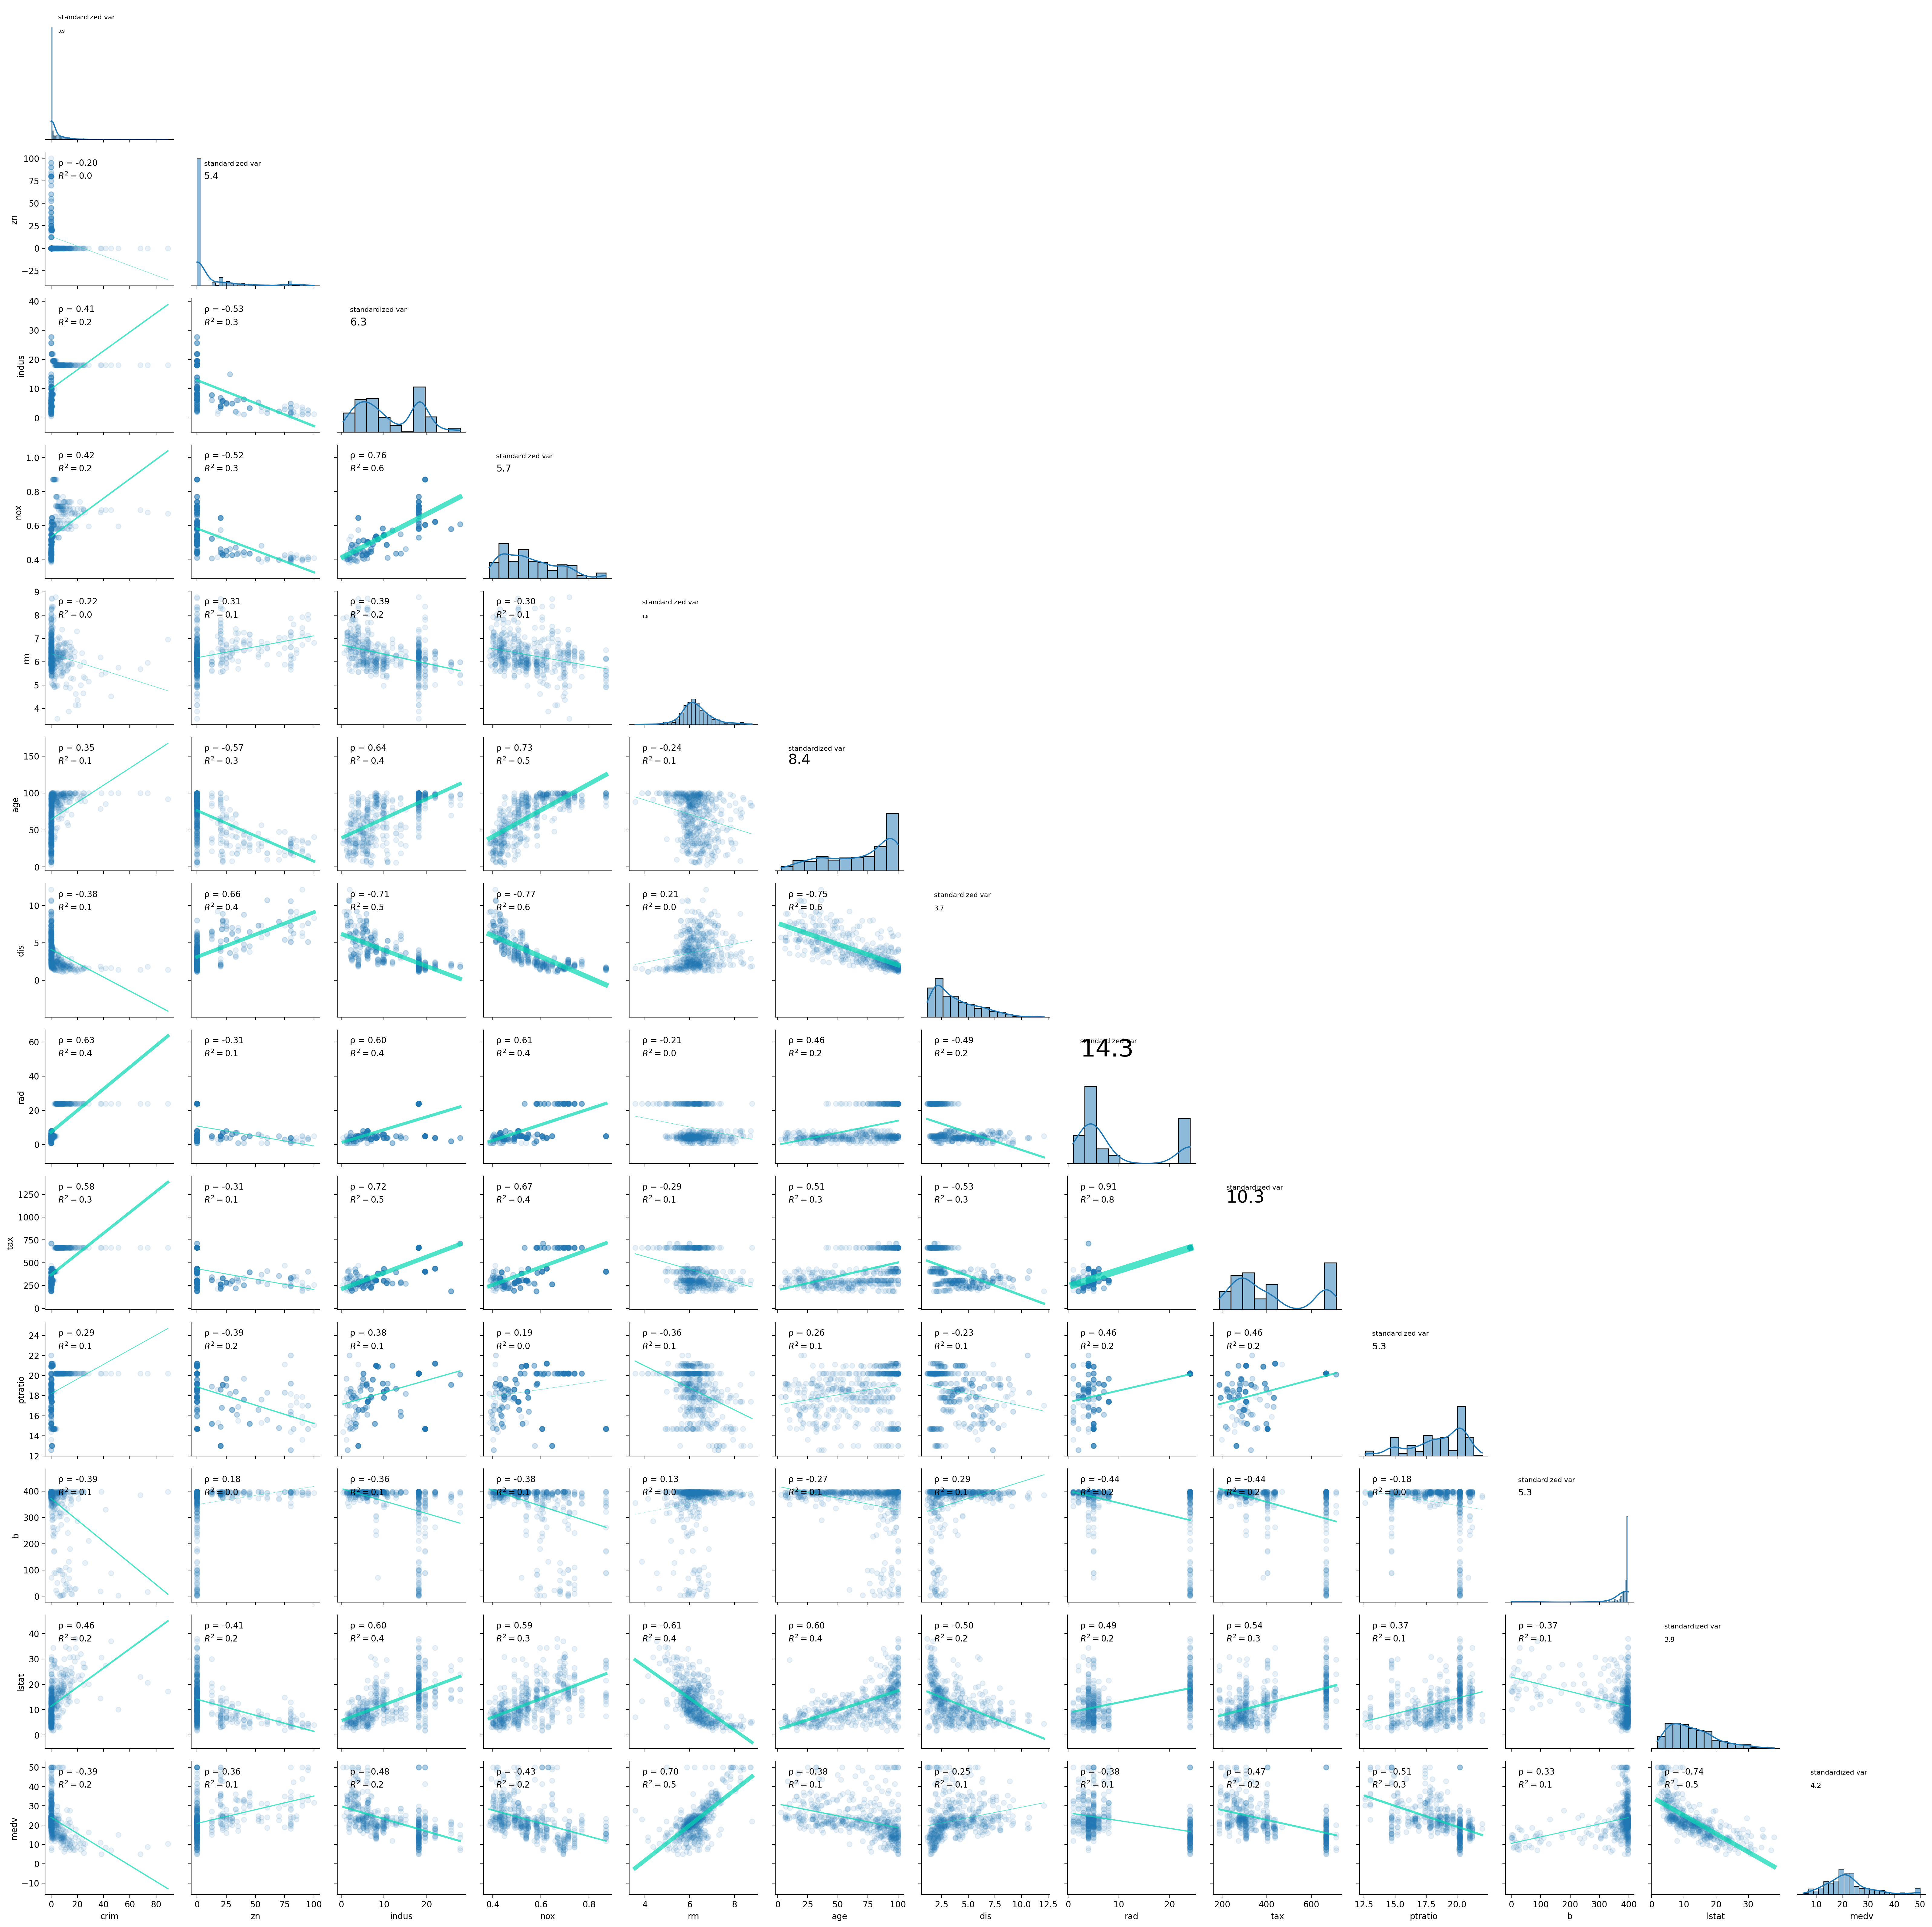

In [282]:
df_numeric_only = df.loc[:, df.columns != "chas"]

df_quick = df.loc[:, df.columns.isin(["crim", "rm", "medv"])]
# df_quick = df.loc[:, df.columns.isin(["chas", "medv"])]


def xy_sort(x, y):
    x_sorted, y_sorted = [list(t) for t in zip(*sorted(zip(x.values, y.values)))]
    return (np.array(x_sorted).reshape(-1, 1), np.array(y_sorted).reshape(-1, 1))


def minmax_scale(x):
    x = [(xx - min(x)) / (max(x) - min(x)) for xx in x]
    return np.array(x)


def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = stats.pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f"ρ = {r:.2f}", xy=(0.1, 0.9), xycoords=ax.transAxes)
    ax.scatter(x, y, alpha=0.1)
    model = LinearRegression()
    # x_
    x, y = xy_sort(x, y)
    # display(x, y)
    model.fit(x, y)
    Rsquared = model.score(x, y)
    ax.plot(
        x, model.predict(x), linewidth=Rsquared * 10, color="xkcd:aquamarine", alpha=0.7
    )
    str = rf"$R^2={round(Rsquared, 1)}$"
    ax.annotate(str, xy=(0.1, 0.8), xycoords=ax.transAxes)


def diagfunc(x, ax=None, **kws):
    ax = ax or plt.gca()
    x_scaled = minmax_scale(x)
    ax.annotate(
        "standardized var",
        xy=(0.1, 0.9),
        xycoords=ax.transAxes,
        fontsize=8,
    )
    v = round(np.var(10 * x_scaled), 1)
    ax.annotate(v, xy=(0.1, 0.8), xycoords=ax.transAxes, fontsize=max(5, v * 2))


g = sns.PairGrid(df_numeric_only, corner=True)

g.map_diag(sns.histplot, kde=True)
g.map_diag(diagfunc, kde=True)
g.map_lower(corrfunc)

Looking at these pairwise correlations, the features with the highest R<sup>2</sup> value (most correlated with the response variable **MEDV**) are **RM**, **PTRATIO**, and **LSTAT**. Let's try fitting linear, quadratic, and cubic regressions with these explanatory variables. I'm not going above a third degree polynomial because I don't want to overfit the data and diminish my model's predictive power.

In [283]:
from sklearn.preprocessing import PolynomialFeatures

features = ["rm", "lstat", "ptratio"]
x = df.loc[
    :,
    df.columns.isin(features),
]
y = df["medv"]

model = LinearRegression()
model.fit(x, y)
Rsquared = model.score(x, y)
print("linear R2   :", Rsquared)

quadratic = PolynomialFeatures(degree=2, include_bias=False)
quadratic_features = quadratic.fit_transform(x, y)
quadratic_fit = LinearRegression()
quadratic_fit.fit(quadratic_features, y)
print("quadratic R2:", quadratic_fit.score(quadratic_features, y))

cubic = PolynomialFeatures(degree=3, include_bias=False)
cubic_features = cubic.fit_transform(x, y)
cubic_fit = LinearRegression()
cubic_fit.fit(cubic_features, y)
print("cubic R2    :", cubic_fit.score(cubic_features, y))

linear R2   : 0.678624160161311
quadratic R2: 0.7965620274818102
cubic R2    : 0.8110442467458959


Okay, my cubic fit <mark>R<sup>2</sup> of 0.811</mark> isn't bad, but we can do better! The **TAX** and **RAD** features also stand out to me because they have very high variance. They are also strongly correlated with each other (R<sup>2</sup> = 0.8).

I looked into adding either of these features, and **TAX** gives me better results. I will only include one of these two to reduce redundancy and keep the model simpler.

In [284]:
features = ["rm", "lstat", "ptratio", "tax"]  # added tax
x = df.loc[
    :,
    df.columns.isin(features),
]
y = df["medv"]

model = LinearRegression()
model.fit(x, y)
Rsquared = model.score(x, y)
print("linear R2   :", Rsquared)

quadratic = PolynomialFeatures(degree=2, include_bias=False)
quadratic_features = quadratic.fit_transform(x, y)
quadratic_fit = LinearRegression()
quadratic_fit.fit(quadratic_features, y)
print("quadratic R2:", quadratic_fit.score(quadratic_features, y))

cubic = PolynomialFeatures(degree=3, include_bias=False)
cubic_features = cubic.fit_transform(x, y)
cubic_fit = LinearRegression()
cubic_fit.fit(cubic_features, y)
print("cubic R2    :", cubic_fit.score(cubic_features, y))

linear R2   : 0.6796626444104407
quadratic R2: 0.8391352726965011
cubic R2    : 0.8839811374283543


That bumped up the quadratic and cubic fit scores, with the cubic <mark>R<sup>2</sup> now at 0.88</mark>. Next, I'll try tinkering with some feature interactions.

In [285]:
features = ["rm", "lstat", "ptratio", "tax"]
x = df.loc[
    :,
    df.columns.isin(features),
]
y = df["medv"]

model = LinearRegression()
model.fit(x, y)
Rsquared = model.score(x, y)
print("linear R2   :", Rsquared)

quadratic = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
quadratic_features = quadratic.fit_transform(x, y)
quadratic_fit = LinearRegression()
quadratic_fit.fit(quadratic_features, y)
print("quadratic R2:", quadratic_fit.score(quadratic_features, y))

cubic = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
cubic_features = cubic.fit_transform(x, y)
cubic_fit = LinearRegression()
cubic_fit.fit(cubic_features, y)
print("cubic R2    :", cubic_fit.score(cubic_features, y))

linear R2   : 0.6796626444104407
quadratic R2: 0.8220293284970571
cubic R2    : 0.8316741758605435


Adding interaction terms lowered the R<sup>2</sup> value, so I am going to leave them out. Next, I am going to trying bringing in the **CHAS** variable that I had omitted from the correlation plots.

In [286]:
features = ["rm", "lstat", "ptratio", "tax", "chas"]
x = df.loc[
    :,
    df.columns.isin(features),
]
y = df["medv"]

model = LinearRegression()
model.fit(x, y)
Rsquared = model.score(x, y)
print("linear R2   :", Rsquared)

quadratic = PolynomialFeatures(degree=2, include_bias=False)
quadratic_features = quadratic.fit_transform(x, y)
quadratic_fit = LinearRegression()
quadratic_fit.fit(quadratic_features, y)
print("quadratic R2:", quadratic_fit.score(quadratic_features, y))

cubic = PolynomialFeatures(degree=3, include_bias=False)
cubic_features = cubic.fit_transform(x, y)
cubic_fit = LinearRegression()
cubic_fit.fit(cubic_features, y)
print("cubic R2    :", cubic_fit.score(cubic_features, y))

linear R2   : 0.6886596276657261
quadratic R2: 0.8511826787038765
cubic R2    : 0.8945022019899681


Adding **CHAS** bumped my cubic model <mark>R<sup>2</sup> value slightly, to 0.89</mark>, so I will include it also as one of my features. 

So now I think I have <mark>the features I want to include in my mode (**RM**, **LSTAT**, **PTRATIO**, **TAX**, and **CHAS**) and I'll use a cubic regression</mark>.

### Time to make a residual plot...

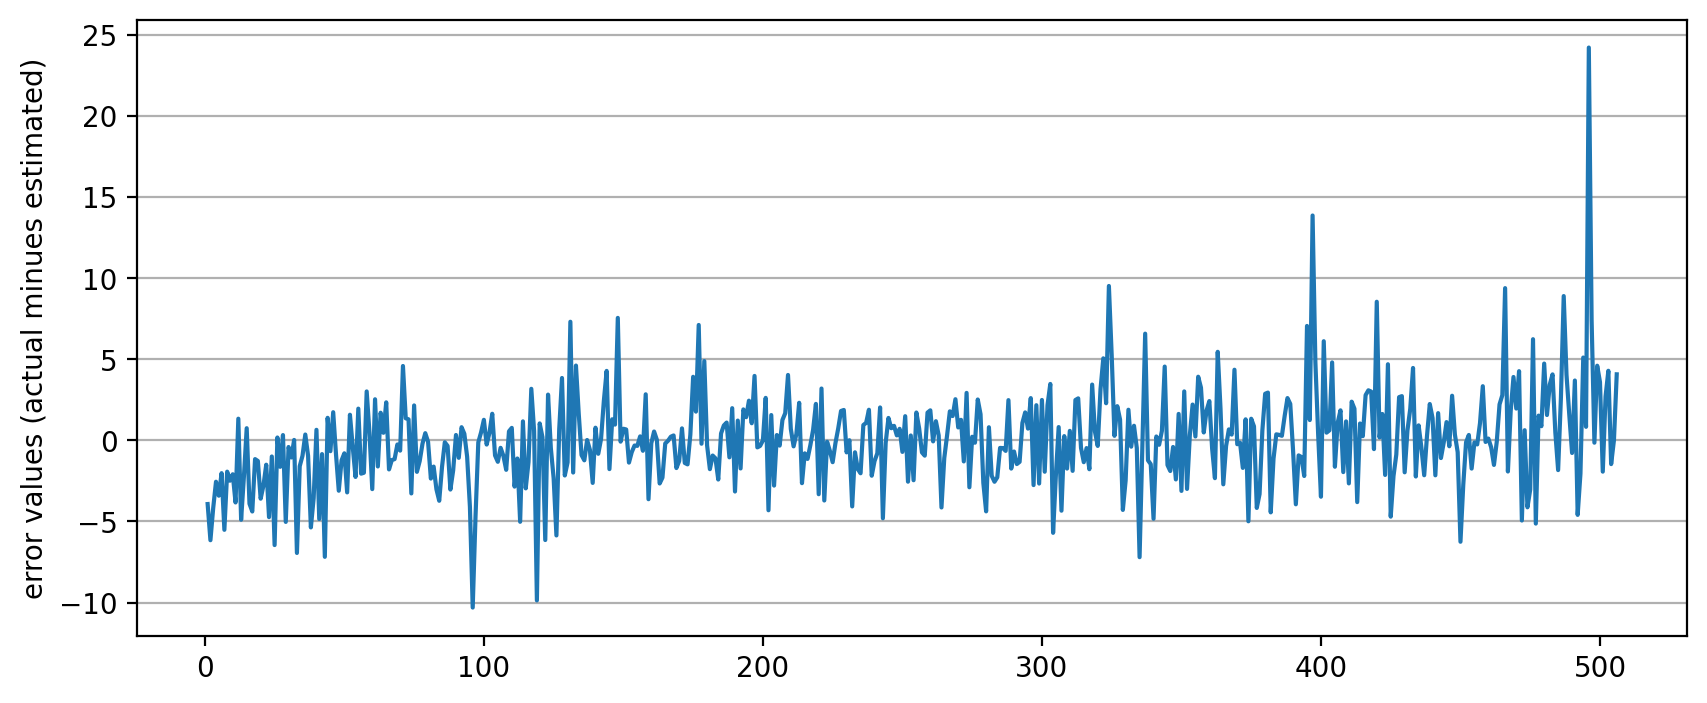

In [287]:
fig, ax = plt.subplots(figsize=(10, 4))

features = ["rm", "lstat", "ptratio", "tax", "chas"]

df_sorted = df.loc[:, df.columns.isin([*features, "medv"])].sort_values("medv")
x = df_sorted.loc[
    :,
    df_sorted.columns.isin(features),
]
y = df_sorted["medv"]

cubic = PolynomialFeatures(degree=3, include_bias=False)
cubic_features = cubic.fit_transform(x, y)
cubic_fit = LinearRegression()
cubic_fit.fit(cubic_features, y)

ax.plot(np.arange(1, len(y) + 1), y - cubic_fit.predict(cubic_features))
ax.set_ylabel("error values (actual minues estimated)")
ax.yaxis.grid(True)

Observations
- The residuals appear to be centered around zero, which is good, showing that the model does not systematically over- or under-predict. 
- There is no clear pattern in the residuals, meaning the model does not suffer from a majorly overlooked nonlinear pattern.
- There are a few outliers, and they are on the positive side, but these outlierse were present in the original dataset and the model struggled to fit them.
- There does not seem to be any autocorrelation in the residuals.
- There is no obvious heteroscedasticity (changing spread of residuals across the range of predicted values).

So it seems like our model is not suffering from any major flaws. So here is our final model:

In [288]:
coeff_names = cubic.get_feature_names_out()
print(len(coeff_names))

coeffs = [
    f"{round(val, 2)} * {coeff_names[ind].upper()}"
    for ind, val in enumerate(cubic_fit.coef_)
]

model_str = f"MEDV = {round(cubic_fit.intercept_, 2)} + {(' + ').join(coeffs)}"
print(model_str)

55
MEDV = 138.94 + 628358.22 * CHAS + 46.5 * RM + -1.44 * TAX + -24.17 * PTRATIO + 15.48 * LSTAT + -314141.42 * CHAS^2 + -16.93 * CHAS RM + 0.02 * CHAS TAX + 4.06 * CHAS PTRATIO + -3.77 * CHAS LSTAT + -6.26 * RM^2 + 0.14 * RM TAX + -0.6 * RM PTRATIO + -3.15 * RM LSTAT + 0.0 * TAX^2 + 0.04 * TAX PTRATIO + -0.02 * TAX LSTAT + 1.26 * PTRATIO^2 + -0.17 * PTRATIO LSTAT + -0.01 * LSTAT^2 + -314141.42 * CHAS^3 + -16.93 * CHAS^2 RM + 0.02 * CHAS^2 TAX + 4.06 * CHAS^2 PTRATIO + -3.77 * CHAS^2 LSTAT + 3.46 * CHAS RM^2 + -0.01 * CHAS RM TAX + -1.41 * CHAS RM PTRATIO + 1.22 * CHAS RM LSTAT + -0.0 * CHAS TAX^2 + 0.01 * CHAS TAX PTRATIO + -0.0 * CHAS TAX LSTAT + 0.02 * CHAS PTRATIO^2 + -0.12 * CHAS PTRATIO LSTAT + 0.08 * CHAS LSTAT^2 + 0.22 * RM^3 + -0.0 * RM^2 TAX + 0.2 * RM^2 PTRATIO + 0.09 * RM^2 LSTAT + 0.0 * RM TAX^2 + -0.01 * RM TAX PTRATIO + 0.0 * RM TAX LSTAT + -0.04 * RM PTRATIO^2 + 0.07 * RM PTRATIO LSTAT + -0.01 * RM LSTAT^2 + 0.0 * TAX^3 + -0.0 * TAX^2 PTRATIO + -0.0 * TAX^2 LSTAT + 0.0 

```
MEDV = 138.95 + -286765.63 * CHAS + 46.49 * RM + -1.44 * TAX + -24.17 * PTRATIO + 15.48 * LSTAT + 143420.5 * CHAS^2 + -16.93 * CHAS RM + 0.02 * CHAS TAX + 4.06 * CHAS PTRATIO + -3.77 * CHAS LSTAT + -6.26 * RM^2 + 0.14 * RM TAX + -0.6 * RM PTRATIO + -3.15 * RM LSTAT + 0.0 * TAX^2 + 0.04 * TAX PTRATIO + -0.02 * TAX LSTAT + 1.26 * PTRATIO^2 + -0.17 * PTRATIO LSTAT + -0.01 * LSTAT^2 + 143420.5 * CHAS^3 + -16.93 * CHAS^2 RM + 0.02 * CHAS^2 TAX + 4.06 * CHAS^2 PTRATIO + -3.77 * CHAS^2 LSTAT + 3.46 * CHAS RM^2 + -0.01 * CHAS RM TAX + -1.41 * CHAS RM PTRATIO + 1.22 * CHAS RM LSTAT + -0.0 * CHAS TAX^2 + 0.01 * CHAS TAX PTRATIO + -0.0 * CHAS TAX LSTAT + 0.02 * CHAS PTRATIO^2 + -0.12 * CHAS PTRATIO LSTAT + 0.08 * CHAS LSTAT^2 + 0.22 * RM^3 + -0.0 * RM^2 TAX + 0.2 * RM^2 PTRATIO + 0.09 * RM^2 LSTAT + 0.0 * RM TAX^2 + -0.01 * RM TAX PTRATIO + 0.0 * RM TAX LSTAT + -0.04 * RM PTRATIO^2 + 0.07 * RM PTRATIO LSTAT + -0.01 * RM LSTAT^2 + 0.0 * TAX^3 + -0.0 * TAX^2 PTRATIO + -0.0 * TAX^2 LSTAT + 0.0 * TAX PTRATIO^2 + 0.0 * TAX PTRATIO LSTAT + 0.0 * TAX LSTAT^2 + -0.03 * PTRATIO^3 + -0.02 * PTRATIO^2 LSTAT + 0.0 * PTRATIO LSTAT^2 + -0.0 * LSTAT^3
```

Well that's interesting. It looks like the `PolynomialFeatures` function I was using automatically includes interaction terms. I'm going to try to remove interaction terms and check how my model would look.

In [289]:
from patsy import dmatrices

# only including 1 CHAS since squaring and cubic it does not change it
formula = "medv ~ I(lstat**3) + I(lstat**2) + lstat + I(rm**3) + I(rm**2) + rm + I(tax**3) + I(tax**2) + tax + I(ptratio**3) + I(ptratio**2) + ptratio + chas"
y_new, x_new = dmatrices(formula, df, return_type="dataframe")

# y_new
x_new
# df_sorted

model = LinearRegression()
model.fit(x_new, y_new)
Rsquared = model.score(x_new, y_new)
print("cubic without interactions R2   :", Rsquared)

cubic without interactions R2   : 0.7930902120046545


Okay, so our cubic fit without interactions is indeed worse than with interactions, so we'll stick with what we had. 

So my final model is a cubic regression using the features **RM**, **LSTAT**, **PTRATIO**, **TAX**, and **CHAS**, with all possible interactions. It has an R<sup>2</sup> value of 0.89 and no patterns in the residual plot.

Typed out, the model looks like this:

MEDV = 138.95 + -286765.63 * CHAS + 46.49 * RM + -1.44 * TAX + -24.17 * PTRATIO + 15.48 * LSTAT + 143420.5 * CHAS^2 + -16.93 * CHAS RM + 0.02 * CHAS TAX + 4.06 * CHAS PTRATIO + -3.77 * CHAS LSTAT + -6.26 * RM^2 + 0.14 * RM TAX + -0.6 * RM PTRATIO + -3.15 * RM LSTAT + 0.0 * TAX^2 + 0.04 * TAX PTRATIO + -0.02 * TAX LSTAT + 1.26 * PTRATIO^2 + -0.17 * PTRATIO LSTAT + -0.01 * LSTAT^2 + 143420.5 * CHAS^3 + -16.93 * CHAS^2 RM + 0.02 * CHAS^2 TAX + 4.06 * CHAS^2 PTRATIO + -3.77 * CHAS^2 LSTAT + 3.46 * CHAS RM^2 + -0.01 * CHAS RM TAX + -1.41 * CHAS RM PTRATIO + 1.22 * CHAS RM LSTAT + -0.0 * CHAS TAX^2 + 0.01 * CHAS TAX PTRATIO + -0.0 * CHAS TAX LSTAT + 0.02 * CHAS PTRATIO^2 + -0.12 * CHAS PTRATIO LSTAT + 0.08 * CHAS LSTAT^2 + 0.22 * RM^3 + -0.0 * RM^2 TAX + 0.2 * RM^2 PTRATIO + 0.09 * RM^2 LSTAT + 0.0 * RM TAX^2 + -0.01 * RM TAX PTRATIO + 0.0 * RM TAX LSTAT + -0.04 * RM PTRATIO^2 + 0.07 * RM PTRATIO LSTAT + -0.01 * RM LSTAT^2 + 0.0 * TAX^3 + -0.0 * TAX^2 PTRATIO + -0.0 * TAX^2 LSTAT + 0.0 * TAX PTRATIO^2 + 0.0 * TAX PTRATIO LSTAT + 0.0 * TAX LSTAT^2 + -0.03 * PTRATIO^3 + -0.02 * PTRATIO^2 LSTAT + 0.0 * PTRATIO LSTAT^2 + -0.0 * LSTAT^3

Below is my summarizing table of models I dismissed. It includes some other models that I tested but didn't document.

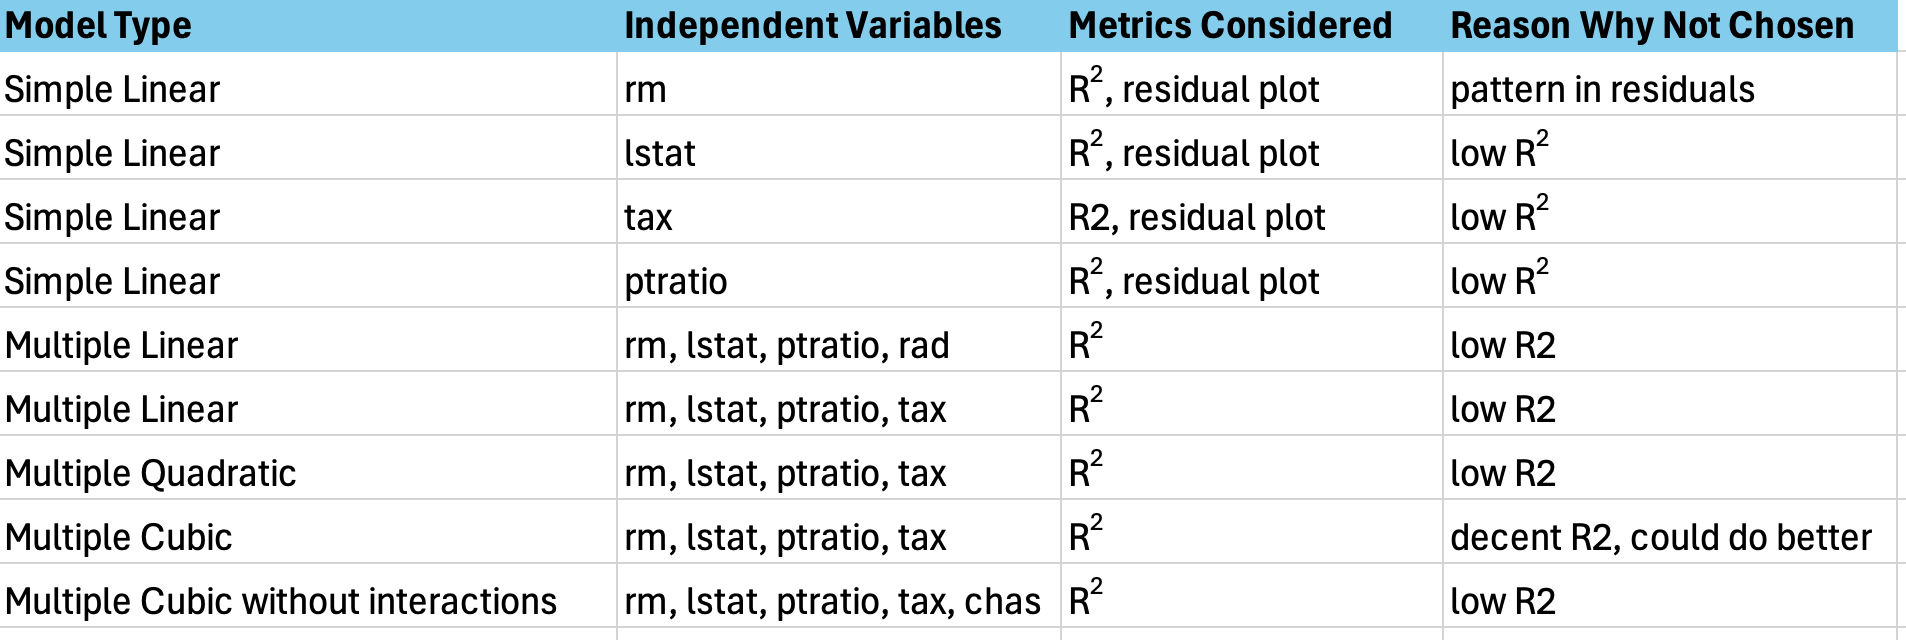
